# 马尔可夫状态模型

## 初始化以及一些方法的定义

In [1]:
%pylab
import pandas
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
#import nglview
#import molpx
#import mdtraj
#from threading import Timer
#from nglview.player import TrajectoryPlayer



import warnings
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=plt.cm.bwr, cbar=True, cbar_label=None):
    # histogram data
    xmin = np.min(xall)
    xmax = np.max(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.min(yall)
    ymax = np.max(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0

    with warnings.catch_warnings() as cm:
        warnings.simplefilter('ignore')
        z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = plt.gca()
    ax.contourf(z.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = plt.colorbar()
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax

def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=plt.cm.Blues, cbar=True, cbar_label=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, cbar=cbar, cbar_label=cbar_label)


def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):  #比较VAMP2 score以及确定降维时的滞后时间
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

Using matplotlib backend: <object object at 0x0000015A36E4A970>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 轨迹文件的读取

In [2]:
files = []
xtc_num=5   # 文件夹下一共有多少个xtc文件,注意：编号要从md1.xtc开始
a=1
while a<=xtc_num:
    files.append('md{}.xtc'.format(a))
    a+=1
pdb ='start.pdb'
print(files)
print(pdb)

['md1.xtc', 'md2.xtc', 'md3.xtc', 'md4.xtc', 'md5.xtc']
start.pdb


## 特征的定义

In [3]:
sw1 = [i for i in range(45,60)] #RBD residue        #定义一些原子对  有变化的环区所有残基的序号
sw2 = [i for i in range(152,170)] #non RBD residue
v51=51
pairs =[]
for i in sw1:
    pairs.append([i,v51])
    for j in sw2:
        pairs.append([i,j])         
for i in sw2:
    pairs.append([i,v51])
pairs=np.array(pairs)
feat = coor.featurizer(pdb)
feat.add_residue_mindist(pairs,periodic=False) #minimum distance between atom pairs of the RBD and non RBD regin
feat_data = coor.load(files, feat)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:06<00:00, 72.68s/it]


In [5]:
# 定义残基范围
residues_54_86 = [i for i in range(54, 87)]  # 54-86号残基
residues_224_226 = [i for i in range(224, 227)]  # 224-226号残基
residues_479_482 = [i for i in range(479, 483)]  # 479-482号残基
residues_520_522 = [i for i in range(520, 523)]  #  20-522号残基

# 生成原子对
pairs = []
for i in residues_54_86:
    for j in residues_224_226:
        pairs.append([i, j])  # 54-86号残基到224-226号残基的距离
    for j in residues_479_482:
        pairs.append([i, j])  # 54-86号残基到479-482号残基的距离
    for j in residues_520_522:
        pairs.append([i, j])  # 54-86号残基到520-522号残基的距离
pairs = np.array(pairs)
feat = coor.featurizer(pdb)
feat.add_residue_mindist(pairs,periodic=False) #minimum distance between atom pairs of the RBD and non RBD regin
feat_data = coor.load(files, feat)

100%|███████████████████████████████████████████| 10/10 [12:02<00:00, 72.20s/it]


In [4]:

print('feat dimension is:',feat.dimension())       #打印出刚才选取了几个feature，有几个就是几维
print('The description of feat is:',feat.describe())     #打印出刚才选取的feature的基本信息
print('n_atoms:', feat.topology.n_atoms)                  #打印出pdb结构中有多少原子
print('type of data:', type(feat_data))               
print('lengths:', len(feat_data))               #打印出这个矩阵的长度，即有多少条轨迹
print('shape of elements:', feat_data[0].shape) # 打印出第一条轨迹的信息，其中行数代表第一条轨迹有多少个frame，列数代表有多少个feature


#This function defines input trajectories without loading them. You can pass the resulting object into transformers such 
#as pyemma.coordinates.tica() or clustering algorithms such as pyemma.coordinates.cluster_kmeans(). Then, the data will be streamed 
#instead of being loaded, thus saving memory.

inp = coor.source(files, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ', 50.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

feat dimension is: 303
The description of feat is: ['RES_DIST (closest-heavy) ARG46 - THR52', 'RES_DIST (closest-heavy) ARG46 - THR153', 'RES_DIST (closest-heavy) ARG46 - GLY154', 'RES_DIST (closest-heavy) ARG46 - ASP155', 'RES_DIST (closest-heavy) ARG46 - ASP156', 'RES_DIST (closest-heavy) ARG46 - LYS157', 'RES_DIST (closest-heavy) ARG46 - GLY158', 'RES_DIST (closest-heavy) ARG46 - GLU159', 'RES_DIST (closest-heavy) ARG46 - SER160', 'RES_DIST (closest-heavy) ARG46 - ASN161', 'RES_DIST (closest-heavy) ARG46 - ASP162', 'RES_DIST (closest-heavy) ARG46 - GLY163', 'RES_DIST (closest-heavy) ARG46 - LYS164', 'RES_DIST (closest-heavy) ARG46 - SER165', 'RES_DIST (closest-heavy) ARG46 - LYS166', 'RES_DIST (closest-heavy) ARG46 - VAL167', 'RES_DIST (closest-heavy) ARG46 - THR168', 'RES_DIST (closest-heavy) ARG46 - HIS169', 'RES_DIST (closest-heavy) ARG46 - VAL170', 'RES_DIST (closest-heavy) ARG47 - THR52', 'RES_DIST (closest-heavy) ARG47 - THR153', 'RES_DIST (closest-heavy) ARG47 - GLY154', 'RES

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.09it/s]


number of trajectories =  5
trajectory length =  400001
trajectory time step =  0.000125 ns
number of dimension =  303


## 特征的保存

In [5]:
data_concatenated = np.concatenate(feat_data)   #将不同轨迹的数据拼接起来，实际上从一个三维矩阵变成了一个二维矩阵
print('shape of elements:', data_concatenated.shape)
print(data_concatenated)
#pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat,ignore_dim_warning=True) #feature的分布，分布越离散越好，因此可以用来选择合适的feature


shape of elements: (2000005, 303)
[[0.4699374  4.3526244  4.587468   ... 4.1920404  4.165009   3.7889228 ]
 [0.48204887 4.3726707  4.6153927  ... 4.2312493  4.21038    3.843638  ]
 [0.4850413  4.366011   4.6031995  ... 4.281239   4.275227   3.890993  ]
 ...
 [0.47333524 4.07833    4.27952    ... 4.2192736  4.148209   3.7449043 ]
 [0.49630728 3.9973018  4.1873574  ... 4.3020825  4.1844444  3.7942686 ]
 [0.5055002  4.012696   4.216406   ... 4.2423     4.123482   3.7148628 ]]


## 特征的PCA降维

In [6]:
import numpy as np
np.bool = bool  # 让 numpy.bool 指向内置 bool 类型
tica = pyemma.coordinates.tica(feat_data, lag=10)    #lag默认是10
tica2 = pyemma.coordinates.tica(feat_data, lag=10,dim=2)    #dim默认是-1，输出占比95%以上的所有向量，比如这里设置2，则只会输出2个向量  
print(tica2.dimension())
print(tica.dimension())
tica_output = tica.get_output()         #输出的就是一个三维矩阵，第一维是轨迹数量，第二维是feature的维度，第三维是feature的数值
tica2_output = tica2.get_output()  # 其实用这个方法，也可以使用dim参数指定输出几个向量
print(np.shape(tica_output))
print('shape of elements:', tica2_output[0].shape) # 打印出第一条轨迹的信息，其中行数代表第一条轨迹有多少个frame，列数代表有多少个feature
print(tica_output[0])   #打印出第一条轨迹的数据
print(tica_output[1])   #打印出第二条轨迹的数据
print(tica_output)   #打印全部数据

print('number of trajectories = ', np.shape(tica_output)[0])
print('number of frames = ', np.shape(tica_output)[1])
print('number of dimensions = ',np.shape(tica_output)[2])

tica_concatenated = np.concatenate(tica_output)   #将数据连接起来，即变成一个二维矩阵了
tica2_concatenated = np.concatenate(tica2_output) 
print(len(tica_concatenated))

C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


2
168


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.10it/s]


(5, 400001, 168)
shape of elements: (400001, 2)
[[-0.86304975 -0.17466265 -0.41829842 ...  0.04877734  0.04275904
   0.01176836]
 [-0.90350246 -0.1340425  -0.2553993  ...  0.22674718 -0.00743283
   0.24753164]
 [-0.89050573 -0.14468168 -0.44336355 ...  0.18277308 -0.42153665
   0.07410572]
 ...
 [-1.126899   -0.31248584 -0.6735669  ... -1.2173069  -0.88020724
  -0.3949402 ]
 [-1.1034502  -0.3518467  -0.68451416 ... -0.67070615 -0.27693224
  -0.47834238]
 [-0.9717296  -0.32258648 -0.8144083  ... -0.2777463  -0.31579992
  -0.08527119]]
[[-0.6005881  -0.18563093  0.07126066 ...  0.56550777 -0.34359103
   0.7359949 ]
 [-0.4847075  -0.34173235  0.25546488 ...  0.20503855  0.31976745
   0.24890482]
 [-0.41256693 -0.39629003  0.35787034 ...  0.3770928   0.8747144
   0.0284434 ]
 ...
 [-1.4215581  -0.73192364 -0.5229365  ... -0.32950294  0.42398483
  -0.5952023 ]
 [-1.4944737  -0.75395423 -0.5685297  ... -0.50130594  1.2992642
  -0.6379229 ]
 [-1.5109054  -0.7178021  -0.48254508 ... -0.3432241

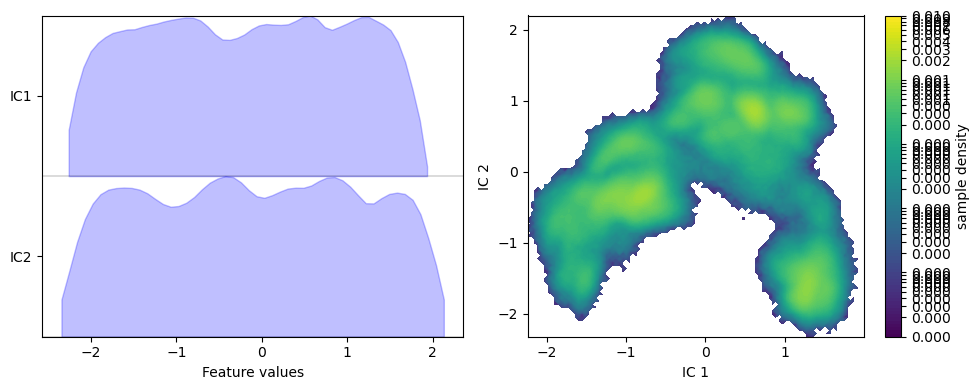

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica2_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True) 
#这个切片操作逗号前表示取这个二维数组的所有行，逗号后表示取前两列，也就是前两个向量，当然也可以直接使用tica2_concatenated.T
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
fig.savefig('G:\derui\shp2\markov_e76k\特征选取.png', dpi=480)

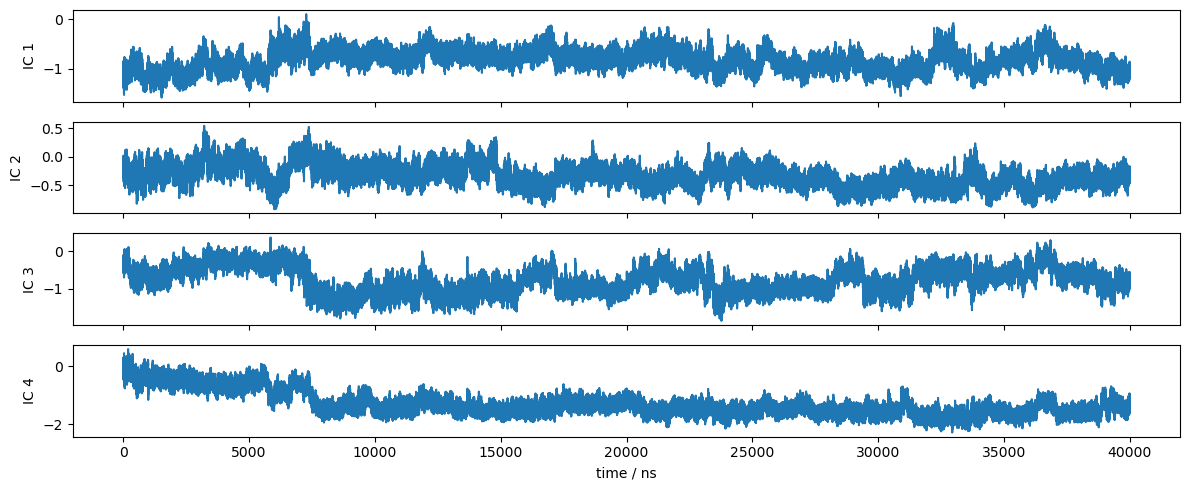

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()    #这张图上面分布越离散，说明选择的越好
fig.savefig('G:\derui\shp2\markov_e76k\离散轨迹.png', dpi=480)

## 聚类

C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:28:56 pyemma.coordinates.clustering.kmeans.KmeansClustering[11] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\e

24-04-25 14:31:14 pyemma.coordinates.clustering.kmeans.KmeansClustering[47] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\e

24-04-25 14:32:35 pyemma.coordinates.clustering.kmeans.KmeansClustering[67] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:32:55 pyemma.coordinates.clustering.kmeans.KmeansClustering[71] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:33:16 pyemma.coordinates.clustering.kmeans.KmeansClustering[75] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:33:35 pyemma.coordinates.clustering.kmeans.KmeansClustering[79] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:33:55 pyemma.coordinates.clustering.kmeans.KmeansClustering[83] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:34:16 pyemma.coordinates.clustering.kmeans.KmeansClustering[87] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:34:38 pyemma.coordinates.clustering.kmeans.KmeansClustering[91] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:35:00 pyemma.coordinates.clustering.kmeans.KmeansClustering[95] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:35:22 pyemma.coordinates.clustering.kmeans.KmeansClustering[99] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:35:45 pyemma.coordinates.clustering.kmeans.KmeansClustering[103] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:36:07 pyemma.coordinates.clustering.kmeans.KmeansClustering[107] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:36:36 pyemma.coordinates.clustering.kmeans.KmeansClustering[111] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:37:04 pyemma.coordinates.clustering.kmeans.KmeansClustering[115] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:37:58 pyemma.coordinates.clustering.kmeans.KmeansClustering[123] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


24-04-25 14:38:56 pyemma.coordinates.clustering.kmeans.KmeansClustering[131] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\dldx\AppData\Local\anaconda3\e

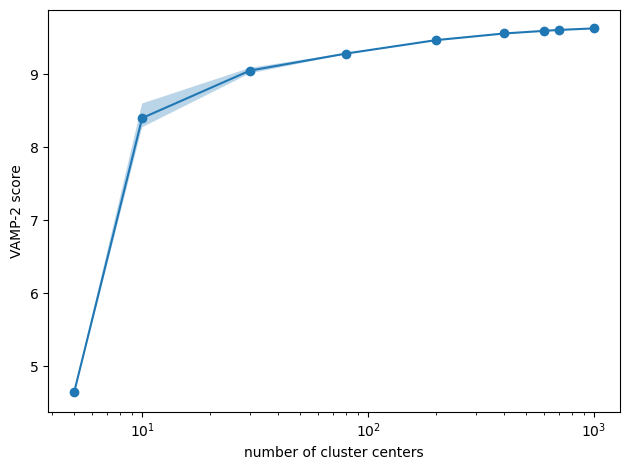

In [11]:
n_clustercenters = [5, 10, 30, 80, 200, 400,600, 700, 1000]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica2_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5) # lag time在这里取5
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()
fig.savefig('G:\derui\shp2\markov_e76k\聚类.png', dpi=480)


In [14]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica2_output, k=800, max_iter=50, stride=10, fixed_seed=1)
dtrajs = cluster.dtrajs   #返回一个二维矩阵，第一维是轨迹个数，第二维是每个frame的聚类号
print(dtrajs)
print(len(dtrajs))
print(np.shape(dtrajs))
print(dtrajs[0])
#print(dtrajs[1])
dtrajs_concatenated = np.concatenate(dtrajs)   #整合成一条轨迹
print(dtrajs_concatenated)
print(len(dtrajs_concatenated))

C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
kmeans iterations: 100%|███████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  8.38it/s]C:\Users\dldx\AppData\Local\anaconda3\envs\py\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 47.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.96it/s]

24-04-25 15:09:42 pyemma.coordinates.clustering.kmeans.KmeansClustering[187] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]

[array([551, 321, 321, ..., 572, 205, 312]), array([  4, 441, 750, ..., 138, 138, 138]), array([735, 334, 334, ..., 549, 785, 130]), array([315,  48,  48, ..., 288, 627, 155]), array([648, 567, 765, ..., 226, 585, 416])]
5
(5, 400001)
[551 321 321 ... 572 205 312]
[551 321 321 ... 226 585 416]
2000005


## 构象分布密度图

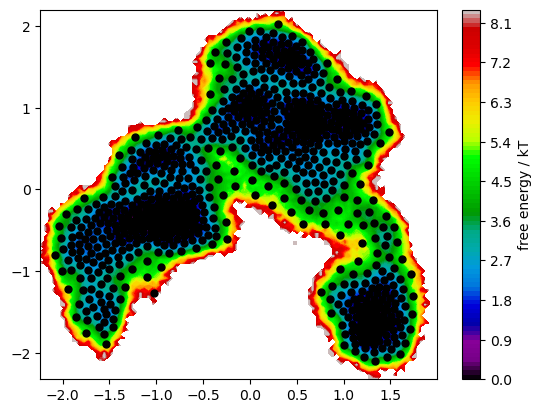

In [15]:
mplt.plot_free_energy(np.vstack(tica2_concatenated)[:,0], np.vstack(tica2_concatenated)[:,1])
cc_x = cluster.clustercenters[:,0]
cc_y = cluster.clustercenters[:,1]
plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')
fig.savefig('G:\derui\shp2\markov_e76k\聚类效果图.png', dpi=480)

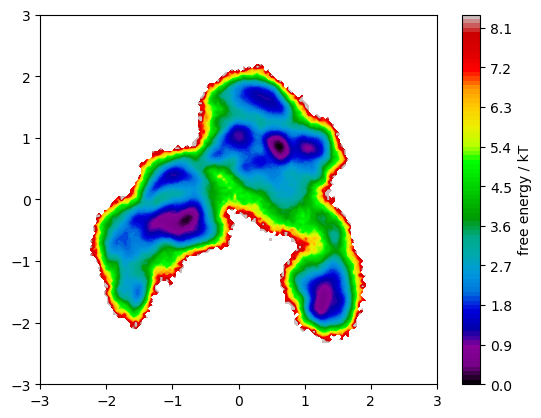

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 tica2_concatenated 和 cluster 是已定义的变量
# 示例数据（请替换为你的实际数据）
# tica2_concatenated = np.array([...])
# cluster = ... # 应包含 clustercenters 属性

# 绘制自由能图
fig, ax = plt.subplots()
mplt.plot_free_energy(np.vstack(tica2_concatenated)[:,0], np.vstack(tica2_concatenated)[:,1], ax=ax)

# 设置纵坐标范围
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

# 获取 cluster center 的坐标
cc_x = cluster.clustercenters[:, 0]
cc_y = cluster.clustercenters[:, 1]

# 绘制 cluster center 点
# plt.plot(cc_x, cc_y, linewidth=0, marker='o', markersize=5, color='black')

# 显示图像
plt.savefig('G:/e76k自由能.png', dpi=300) # 保存图像到D盘，分辨率为300 DPI
plt.show()
fig.savefig('G:\derui\shp2\markov_e76k\自由能.png', dpi=480)

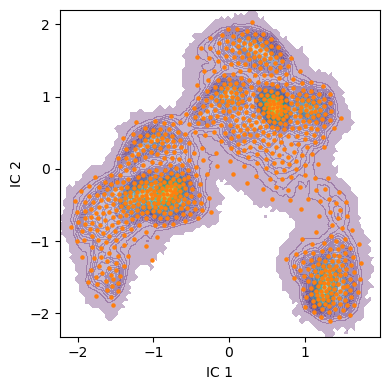

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica2_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
plt.show()
fig.savefig('G:\derui\shp2\markov_e76k\聚类分散.png', dpi=480)

## 滞后时间（lag time）的确定

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:02<00:00,  7.84s/it]


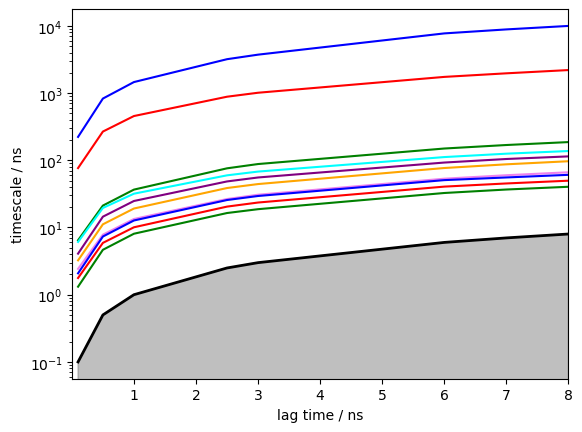

In [21]:
import pyemma
import numpy as np

# 确保数据是 NumPy 数组，而不是 mmap 映射对象
cluster_dtrajs = [np.array(traj) for traj in cluster.dtrajs]

its = pyemma.msm.its(cluster_dtrajs, lags=[10,50,100,250,300,600,700,800], nits=10, errors=None)
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.01);
fig.savefig('G:\derui\shp2\markov_e76k\滞后时间1.png', dpi=480)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:58<00:00,  6.99s/it]


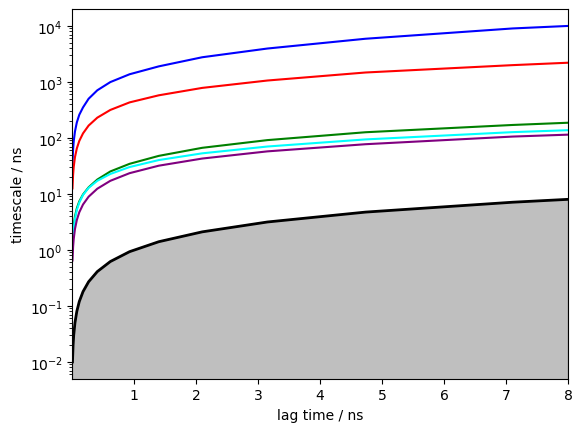

In [22]:
 #这里的每一步抽样时间为0.1ns，我们平时模拟一般设置为0.01ns
import pyemma
import matplotlib.pyplot as plt

its = pyemma.msm.its(cluster.dtrajs, lags=800, nits=5, errors=None)

# 创建图对象
fig, ax = plt.subplots()
pyemma.plots.plot_implied_timescales(its, ax=ax, units='ns', dt=0.01)

# 保存图像
fig.savefig(r'G:\derui\shp2\markov_e76k\滞后时间.png', dpi=480, bbox_inches='tight')


## 模型构建

In [23]:
msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=800, dt_traj='0.01 ns')
# 建立 MSM active set 的映射关系
mapping = -np.ones(cluster.n_clusters, dtype=int)
mapping[msm.active_set] = np.arange(len(msm.active_set))
mapped_dtrajs = [mapping[traj] for traj in dtrajs]
mapped_dtrajs_concatenated = np.concatenate(mapped_dtrajs)

print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))
P=msm.P
print(P)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


fraction of states used = 1.00
fraction of counts used = 1.00
[[2.47349824e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.12213742e-02 0.00000000e+00 ... 9.68722528e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.73420141e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.99222240e-04 0.00000000e+00 ... 7.52169723e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  4.02684564e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.39316240e-02]]


## Chapman-Kolmogorov test

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:28<00:00, 113.62s/it]


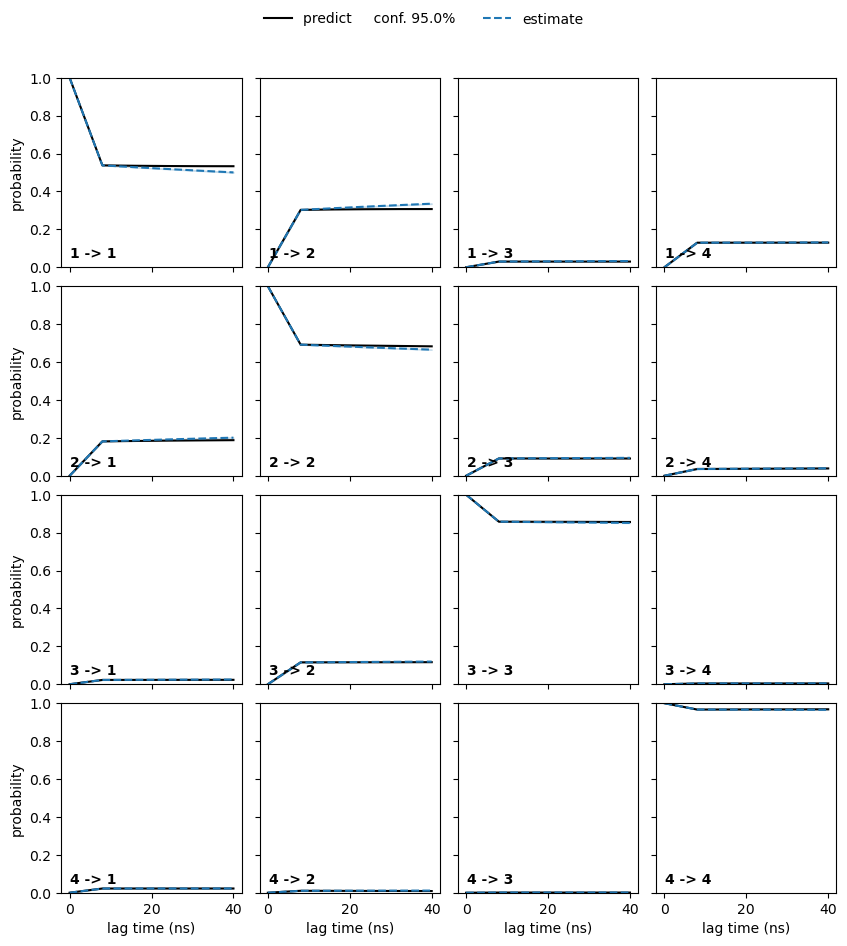

In [27]:
import numpy as np
np.float = np.float64
nstates = 4
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.01, units='ns');
plt.show()
fig.savefig('G:\derui\shp2\markov_e76k\模型检验.png', dpi=480)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:46<00:00, 141.31s/it]


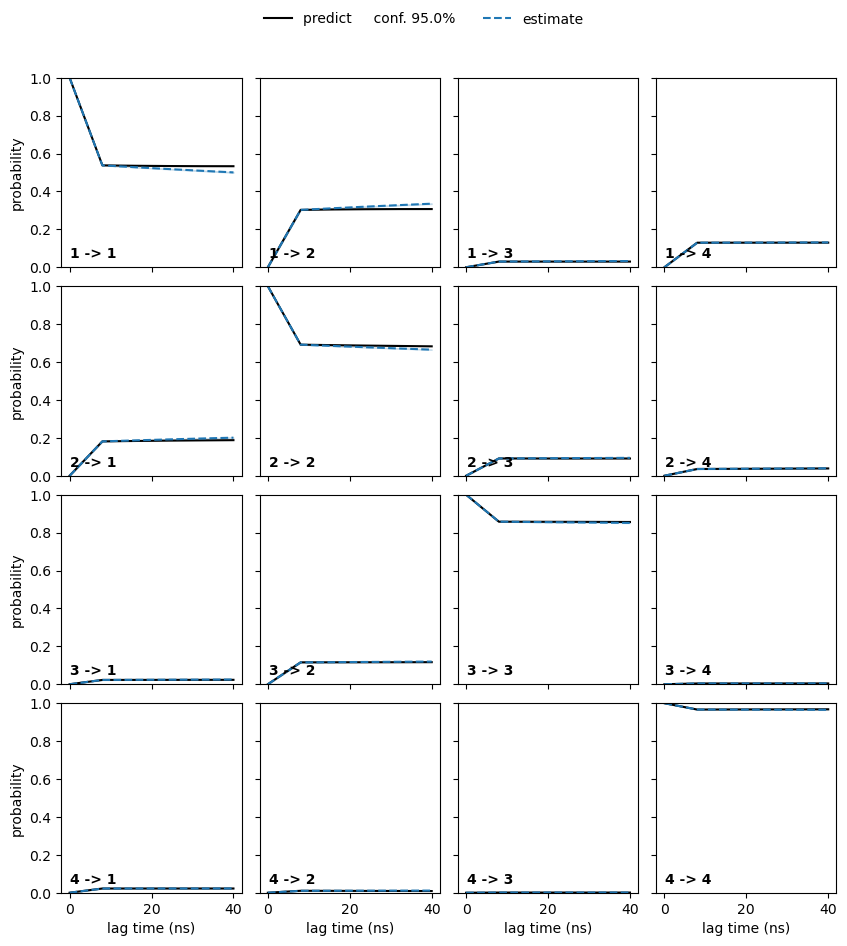

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pyemma

np.float = np.float64
nstates = 4

# 计算 cktest
cktest = msm.cktest(nstates, mlags=6)

# 直接绘图，不传 ax
pyemma.plots.plot_cktest(cktest, dt=0.01, units='ns')

# 获取当前图
fig = plt.gcf()

# 保存图片
fig.savefig(r'G:\derui\shp2\markov_e76k\模型检验.png', dpi=480, bbox_inches='tight')

# 显示图片
plt.show()


## MSM spectral analysis

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of ticklabels (16).

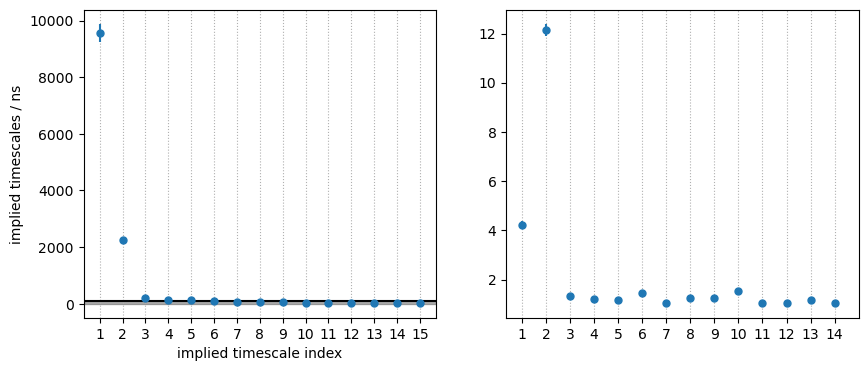

In [18]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

## 自由能图谱和平衡分布

[  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  21
  22  23  25  26  27  28  30  31  32  33  34  35  36  37  38  40  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  63  64  65  66  67  69  70  71  73  74  75  76  79  80  81  82  83  85
  87  88  89  90  92  93  94  95  96  97  98  99 101 102 103 104 106 107
 110 111 112 114 116 117 118 119 120 122 123 125 126 127 129 130 131 133
 134 135 136 137 138 139 140 141 142 143 144 145 147 148 149 150 151 152
 154 155 156 157 158 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 176 178 180 181 182 183 184 185 186 187 189 190 192 193 194 196
 197 198 199 200 201 202 203 204 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 224 225 226 227 228 229 230 231 232 233 236
 237 242 243 244 246 247 249 250 251 252 253 254 255 256 257 258 259 260
 261 263 264 265 266 268 269 270 271 275 276 278 279 280 281 282 283 284
 286 288 289 290 291 292 293 294 295 296 297 298 29

IndexError: index 799 is out of bounds for axis 0 with size 662

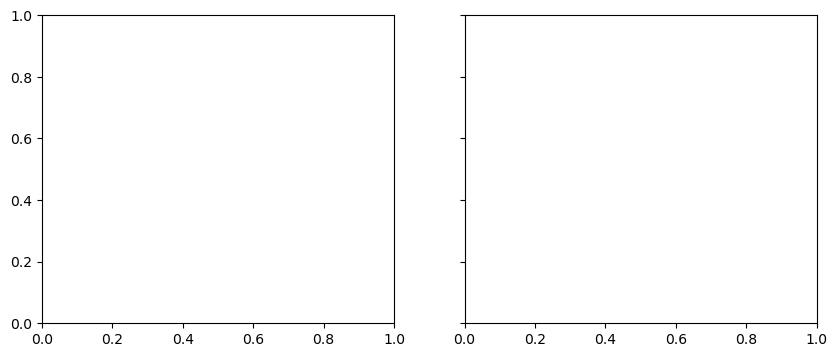

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
print(msm.active_set)
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))
print(msm.pi)
print(dtrajs_concatenated)
print(len(msm.pi[dtrajs_concatenated]))

pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[mapped_dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

MSM active set: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 24

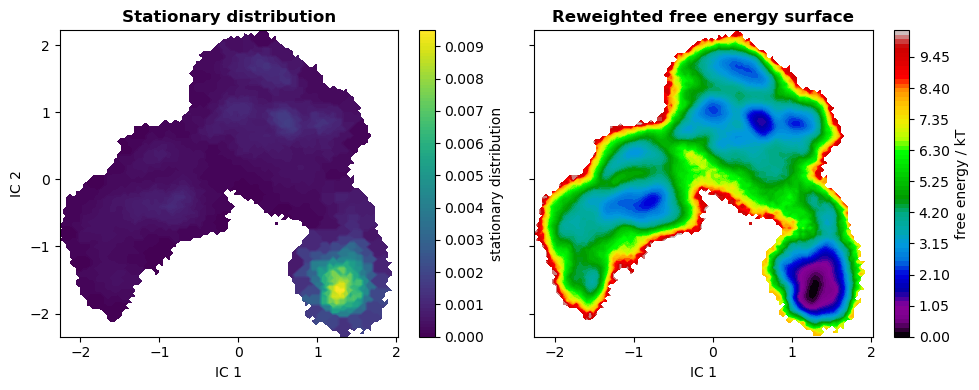

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# 输出 MSM 信息
print("MSM active set:", msm.active_set)
print("MSM stationary distribution (pi):", msm.pi)
print("sum of weights = {:f}".format(msm.pi.sum()))
print("映射后的轨迹状态:", mapped_dtrajs_concatenated)
print("长度:", len(mapped_dtrajs_concatenated))

# 绘制平衡分布
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[mapped_dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')

# 绘制重加权自由能面
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)

# 设置图形格式
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
fig.savefig('G:\derui\shp2\markov_e76k\自由能平衡分布.png', dpi=480)

## 微观态到宏观态的聚类

The first eigenvector is one: True (min=0.9999999999923654, max=1.0000000000040843)


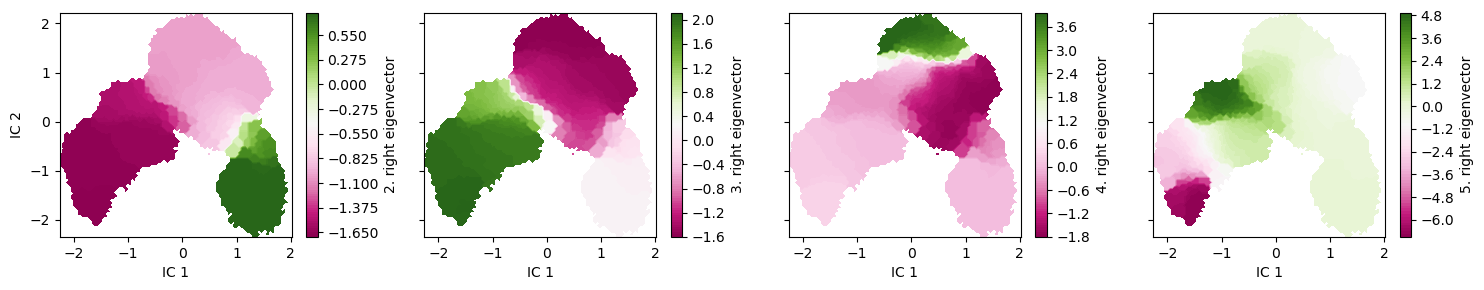

In [20]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)   #这里的4代表上面设置了4个nstates，做4张图
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[mapped_dtrajs_concatenated, i+1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [21]:
nstates=4
pcca=msm.pcca(nstates)
print(pcca.transition_matrix)
pcca_dist = msm.metastable_distributions
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

[[2.47349824e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.23901942e-02 0.00000000e+00 ... 9.87440832e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.73420141e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 2.02431411e-04 0.00000000e+00 ... 7.52169723e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  4.02684564e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.39316240e-02]]
π_1 = 0.060046
π_2 = 0.191151
π_3 = 0.142646
π_4 = 0.606157


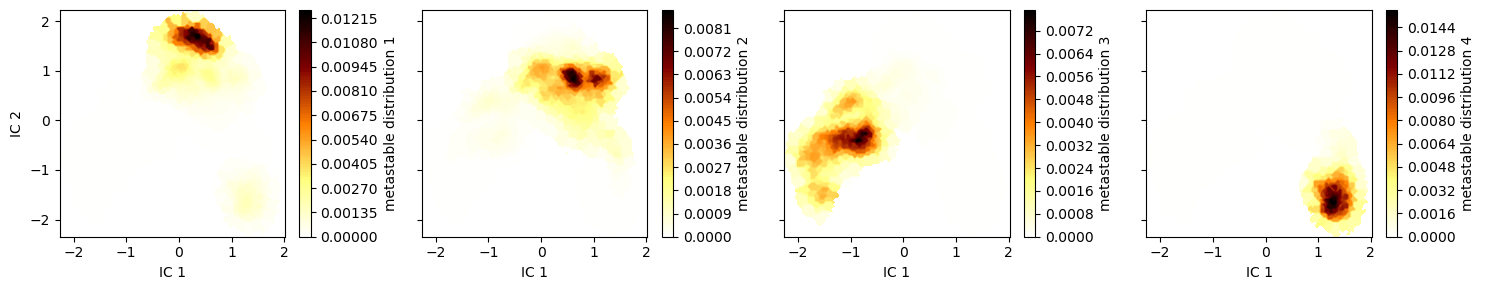

In [22]:
fig, axes = plt.subplots(1, nstates, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][mapped_dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

## 动力学性质分析

In [23]:
metastable_traj = msm.metastable_assignments[mapped_dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [24]:
from itertools import product
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])
from pandas import DataFrame


#mfpt = mfpt/1e3   
inverse_mfpt = np.zeros_like(mfpt)
#nz = mfpt.nonzero()
#inverse_mfpt[nz] = 1.0 / mfpt[nz]

print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))
#DataFrame(np.round(inverse_mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))
#print(mfpt)

MFPT / ns:


,1,2,3,4
1,0.00,203.72,16415.05,9216.11
2,2886.26,0.00,16465.04,8785.61
3,6730.61,3010.45,0.00,12646.96
4,24732.94,15350.96,37742.01,0.00


In [26]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))#可以理解为在聚类中，每个大类所含有的构象个数的百分比，这个数值即stationary_distribution不一定一样
print(msm.pi)

state	π		G/kT
1	0.060046	2.812644
2	0.191151	1.654692
3	0.142646	1.947390
4	0.606157	0.500616
[5.55428297e-04 7.07109685e-04 9.46546092e-03 4.99209172e-04
 6.82030518e-04 2.67220767e-04 1.31807838e-03 3.45651234e-04
 9.86523516e-04 1.15992627e-03 5.27226982e-04 4.75061619e-03
 4.76277622e-04 3.65403861e-04 1.52238892e-03 3.56152018e-04
 8.77351982e-04 4.54294987e-04 4.41978610e-04 8.29885109e-04
 3.26320973e-04 1.32519518e-03 5.00643416e-04 2.26536668e-04
 3.88784210e-04 5.29115036e-04 5.21444313e-03 5.69719198e-03
 4.57552462e-04 4.10578824e-04 4.33948120e-04 4.83012607e-04
 5.33302503e-04 6.31949898e-04 8.84355726e-03 3.62262808e-04
 3.76002563e-04 9.13709888e-04 9.26747072e-04 2.50142208e-04
 6.97943923e-04 1.24052650e-03 8.24831480e-03 8.93355849e-04
 7.31934941e-04 6.99386326e-04 1.18344722e-03 1.81717652e-04
 4.86758780e-04 4.97286198e-03 3.07194372e-03 5.77070597e-04
 2.43169720e-04 8.94497558e-04 8.12536466e-04 2.09277885e-04
 1.04601775e-03 8.62479645e-04 4.39275764e-04 3.2385

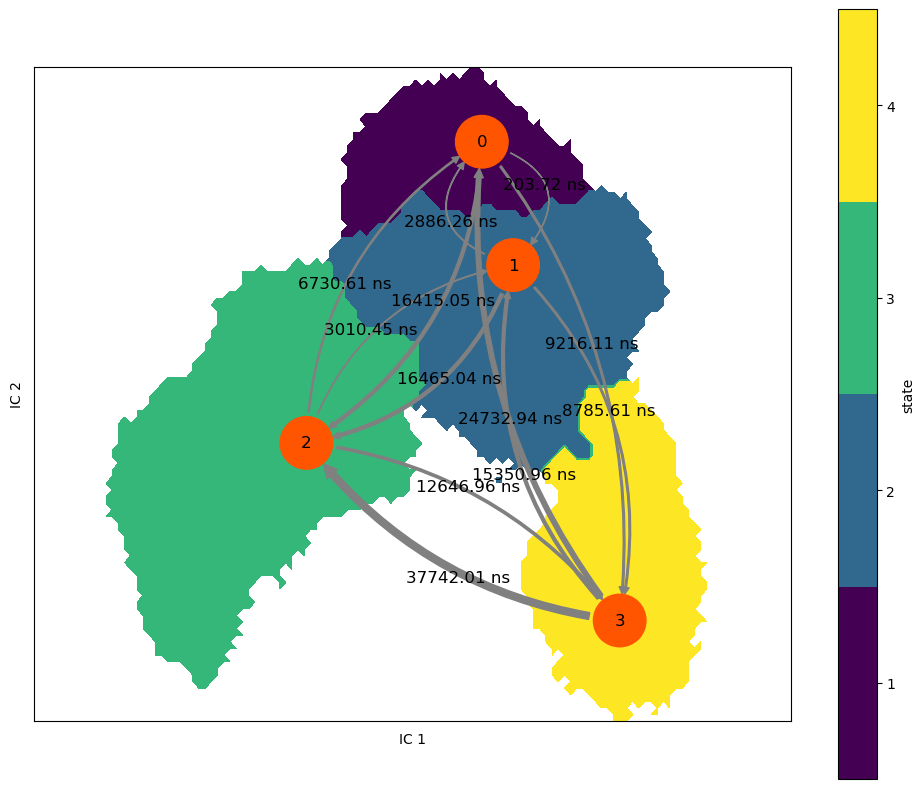

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *tica2_concatenated.T, metastable_traj, ax=ax, zorder=-1)  #此处必须读入一个二维或者2列的数据才可以作图
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates
fig.tight_layout()



pyemma.plots.plot_network(
    mfpt,
    #inverse_mfpt,
    pos=coarse_state_centers,
    #state_sizes=cgflux.stationary_distribution,  #根据上面计算的构象分布概率来决定圆圈的大小，当然也可以自己定义一个矩阵决定圆圈大小
    figpadding=2,
    ax=ax,
    state_colors = '#ff5500',  #表示颜色数值,也可以自己查表进行更改
    arrow_label_format='%.2f ns',    #箭头上的数字是PS的小数数字表示
    #arrow_label_format='%2.e / ns',  #箭头上的数字是PS的常用对数表示
    #arrow_labels=mfpt,
    size=12,     #表示上面数字的大小
    state_scale=0.05,   #圆圈的大小尺寸
    arrow_scale=1.0,   #线条粗细，默认是1.0
    show_frame=True
    )

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

# 设置纵坐标范围
ax.set_ylim([-10, 10])
ax.set_xlim([-10, 10])


#print(msm.pi)



ax.set_xlim(tica2_concatenated[:, 0].min()-0.5, tica2_concatenated[:, 0].max()+0.5)
ax.set_ylim(tica2_concatenated[:, 1].min(), tica2_concatenated[:, 1].max())
ax.set_aspect('equal',adjustable='box')  #自动缩放坐标轴
fig.tight_layout()

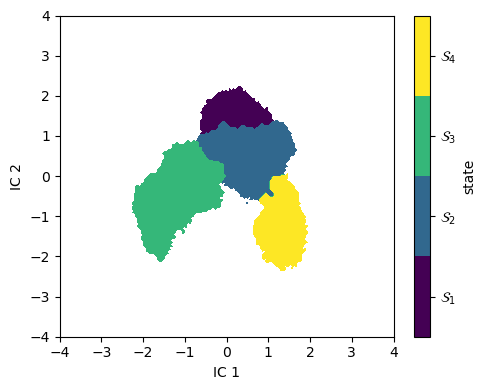

In [28]:
fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])
fig.savefig('G:\derui\shp2\markov_e76k\state.png')
fig.tight_layout()
fig.savefig('G:\derui\shp2\markov_e76k\聚类分布.png', dpi=480)

## 代表性结构的提取

In [29]:
import mdtraj as md

# 加载所有轨迹
all_trajs = [md.load(xtc, top='start.pdb') for xtc in files]

# 获取样本帧的索引
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 1)

# 逐个保存
for i, samples in enumerate(pcca_samples):
    traj_list = []
    for traj_index, frame_index in samples:
        traj_list.append(all_trajs[traj_index][frame_index])
    traj_out = traj_list[0].join(traj_list[1:]) if len(traj_list) > 1 else traj_list[0]
    traj_out.save_pdb(f"pcca{i+1}-samples.pdb")
